In [1]:
import torch
import wandb
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = "mps"

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, c_dim):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(c_dim, c_dim, kernel_size=3, stride=1, padding="same", bias=False)
        self.norm1 = nn.InstanceNorm2d(c_dim, affine=True)
        self.conv2 = nn.Conv2d(c_dim, c_dim, kernel_size=3, stride=1, padding="same", bias=False)
        self.norm2 = nn.InstanceNorm2d(c_dim, affine=True)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = F.relu(self.norm1(out))
        out = self.norm2(self.conv2(out))
        out += residual # residual connection
        # downsample
        out = F.max_pool2d(out, 2)
        out = F.relu(out)
        return out


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # cnn based encoder
        # each residual block has reduces the image size by 2x (we start with 28x28)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=4, stride=1, padding="same", bias=False)
        self.norm1 = nn.InstanceNorm2d(64, affine=True)
        self.res1 = ResidualBlock(64) # 64x14x14
        self.res2 = ResidualBlock(64) # 64x7x7
        self.res3 = ResidualBlock(64) # 64x3x3
        self.conv2 = nn.Conv2d(64, 40, kernel_size=3, stride=1, bias=False)


    def forward(self, x):
        # cnn based encoder
        x = F.relu(self.norm1(self.conv1(x)))
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.conv2(x)
        x = x.view(-1, 40)
        mu = x[:, :20]
        logvar = x[:, 20:]
        return mu, logvar

In [30]:
class TransposeConvBlock(nn.Module):
    def __init__(self, c_in, c_out, kernel_size=3, stride=1):
        super(TransposeConvBlock, self).__init__()
        self.conv = nn.ConvTranspose2d(c_in, c_out, kernel_size=kernel_size, stride=stride, bias=False)
        self.norm = nn.BatchNorm2d(c_out)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(self.norm(x))
        return x

# cnn based decoder (transposed convolutions starting with one pixel with channel dim 20)
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv_blocks = nn.Sequential(
            TransposeConvBlock(20, 64, kernel_size=3, stride=1),
            nn.Upsample(scale_factor=2),
            TransposeConvBlock(64, 64, kernel_size=3, stride=1),
            TransposeConvBlock(64, 64, kernel_size=3, stride=1),
            TransposeConvBlock(64, 64, kernel_size=3, stride=1),
            nn.Upsample(scale_factor=2),
            TransposeConvBlock(64, 32, kernel_size=3, stride=1),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, bias=False),
            nn.BatchNorm2d(1),
        )

    def forward(self, z):
        x = z.view(-1, 20, 1, 1)
        return self.conv_blocks(x)

In [31]:
def kl_divergence(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

In [32]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        mu, logvar = self.encoder(x)
        kl_div = kl_divergence(mu, logvar)
        z = self.sample(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, kl_div

    def sample(self, mu, logvar) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

In [16]:
# load images
MEAN = 0.1307
STD = 0.3081
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD), # mean and std of MNIST
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [33]:
vae = VAE().to(device)
optimizer = torch.optim.AdamW(vae.parameters(), lr=1e-3)

In [ ]:
# set up wandb logging
wandb.init(
    project="vae_experiments",
    config={
        "epochs": 20,
        "batch_size": 64,
        "learning_rate": 1e-3,
        "optimizer": "AdamW",
        "total_loss": "MSE + KL",
        "architecture": "CNN based",
        "activation": "ReLU",
        "latent_dim": 20,
        "dataset": "MNIST"
    },
    name="final"
)

In [ ]:
# training loop
vae.train()
sampled_z = torch.randn(1, 20).to(device)
for epoch in range(20):
    for batch_idx, (image, _) in enumerate(train_loader):
        image = image.to(device)
        # image = image.view(image.size(0), -1)
        optimizer.zero_grad()
        x_hat, kl_div = vae(image)
        reconstruction_loss = F.mse_loss(x_hat, image, reduction="sum")
        loss = reconstruction_loss + kl_div
        wandb.log({"total_loss": loss.item()})
        wandb.log({"kl_div": kl_div.item()})
        wandb.log({"reconstruction_loss": reconstruction_loss.item()})
        
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            with torch.no_grad():
                print(f"Epoch: {epoch} | Batch: {batch_idx} | Loss: {loss.item()}")
                
    with torch.no_grad():
        # sample random image from gaussian
        vae.eval()
        sampled_x = vae.decoder(sampled_z)
        # denomralize image
        sampled_x = (sampled_x * STD + MEAN).clamp(0, 1)
        x_hat = (x_hat * STD + MEAN).clamp(0, 1)
        image = (image * STD + MEAN).clamp(0, 1)
        wandb.log({
            "images": [
                wandb.Image(image[0].view(28, 28)),
                wandb.Image(x_hat[0].view(28, 28)),
                wandb.Image(sampled_x[0].view(28, 28))
            ]
        })
        vae.train()

In [36]:
# testing loss over entire test set
vae.eval()
with torch.no_grad():
    test_loss = 0
    for batch_idx, (image, _) in enumerate(test_loader):
        image = image.to(device)
        x_hat, kl_div = vae(image)
        reconstruction_loss = F.mse_loss(x_hat, image, reduction="sum")
        loss = reconstruction_loss + kl_div
        test_loss += loss.item()
    print(f"Test loss: {test_loss / len(test_loader)}")
        

Test loss: 6386.20294617088


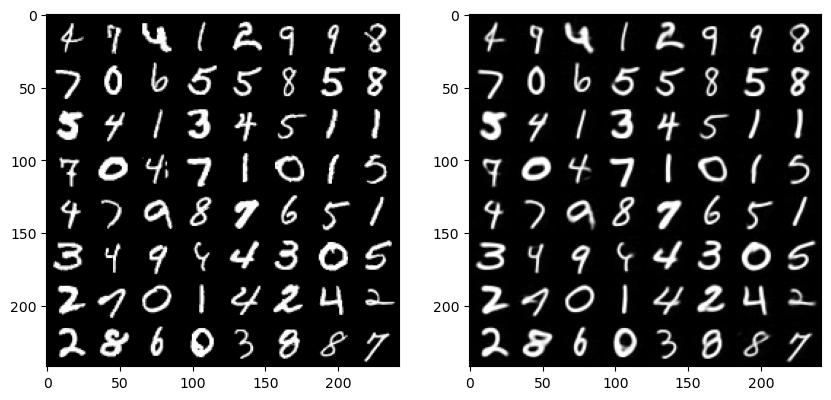

In [37]:
# plotting images vs reconstructed images
images = next(iter(test_loader))[0].to(device)

with torch.no_grad():
    vae.eval()
    x_hat, _ = vae(images)
    x_hat = x_hat.view(x_hat.size(0), 1, 28, 28)

    # denormalize images
    x_hat = x_hat * STD + MEAN
    images = images * STD + MEAN

    # plotting images
    x_hat = x_hat.view(-1, 1, 28, 28).clamp(0, 1)
    images = images.view(-1, 1, 28, 28).clamp(0, 1)

    # turn x_hat and images into grids
    x_hat = torchvision.utils.make_grid(x_hat, nrow=8).permute(1, 2, 0).cpu().numpy()
    images = torchvision.utils.make_grid(images, nrow=8).permute(1, 2, 0).cpu().numpy()

    # plot images
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(images, cmap="gray")
    ax[1].imshow(x_hat, cmap="gray")
    plt.show()

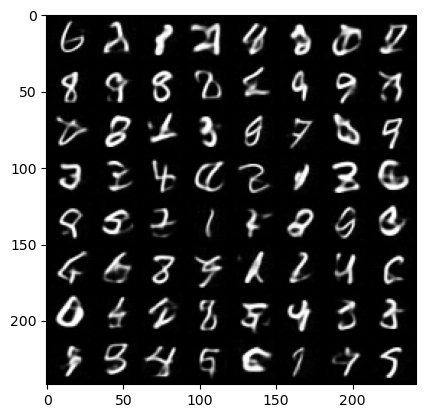

In [38]:
# sample random images from the latent space
with torch.no_grad():
    vae.eval()
    z = torch.randn(64, 20).to(device)
    x_hat = vae.decoder(z)
    x_hat = x_hat.view(-1, 1, 28, 28)

    # denormalize images
    x_hat = (x_hat * STD + MEAN).clamp(0, 1)

    # plot images
    plt.imshow(torchvision.utils.make_grid(x_hat, nrow=8).permute(1, 2, 0).cpu().numpy())

tensor(2.8215, device='mps:0') tensor(-0.4242, device='mps:0')


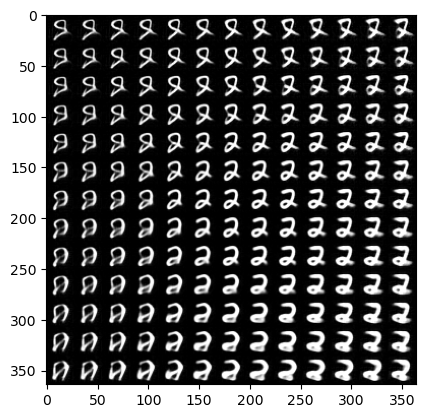

In [45]:
# tweak the first component of the latent vector
with torch.no_grad():
    width = 13
    tweak_spectrum = [[0] * width for _ in range(width)]
    vae.eval()
    shifts = torch.linspace(-7, 7, width).to(device)
    x = next(iter(test_loader))[0][0].to(device).unsqueeze(0)
    print(x.max(), x.min())
    z, _ = vae.encoder(x)
    for i in range(width):
        for j in range(width):
            tweaked_z = z.clone().squeeze()
            tweaked_z[2] = tweaked_z[2] + shifts[i]
            tweaked_z[18] = tweaked_z[18] + shifts[j]
            x_hat = vae.decoder(tweaked_z.unsqueeze(0))
            x_hat = x_hat.view(-1, 1, 28, 28)

            # denormalize images
            x_hat = (x_hat * STD + MEAN).clamp(0, 1)
            
            tweak_spectrum[i][j] = x_hat

    # represent the images as a grid
    tweak_spectrum = torch.cat([torch.cat(row, dim=3) for row in tweak_spectrum], dim=2)
    tweak_spectrum = tweak_spectrum.view(tweak_spectrum.size(0), 1, 28 * width, 28 * width)

    # plot the grid of images in matplotlib
    plt.imshow(tweak_spectrum[0].cpu().numpy().squeeze(), cmap="gray")
    plt.show()
    